# Notebook: Advanced Modeling & Evaluation (Task 7)
Best Model: Decision Tree


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

%matplotlib inline

In [28]:

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

RANDOM_STATE = 42

# If your timestamps are 10ms apart, fs ≈ 100 Hz; keep fixed for spectral features.
FS = 100.0

# At least 10 window sizes
WINDOW_SIZES = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0]

# 50% overlap
OVERLAP = 0.5

# Model hyperparams (keep simple per rubric)
MAX_DEPTH = 5

# Column names
ts_col = "Timestamp"
id_col = "Athlete_ID"
label_col = "Event_Label"

In [29]:
DATA_PATH = Path("../data/biosensor_preprocessed_all.csv")

assert DATA_PATH.exists(), f"Missing file: {DATA_PATH}"

df = pd.read_csv(DATA_PATH, parse_dates=[ts_col])
df = df.sort_values([id_col, ts_col]).reset_index(drop=True)

print("Rows:", len(df))
print("Athletes:", df[id_col].nunique())
print("Labels:", df[label_col].nunique())

Rows: 1500
Athletes: 5
Labels: 6


In [30]:
def find_col_like(cols, keywords):
    for c in cols:
        cl = c.lower()
        if any(k in cl for k in keywords):
            return c
    return None

# Detect accel/gyro axes (if present)
acc_x = find_col_like(df.columns, ["acc_x", "accx", "acc x"])
acc_y = find_col_like(df.columns, ["acc_y", "accy", "acc y"])
acc_z = find_col_like(df.columns, ["acc_z", "accz", "acc z"])

gyro_x = find_col_like(df.columns, ["gyro_x", "gyrox", "gyro x"])
gyro_y = find_col_like(df.columns, ["gyro_y", "gyroy", "gyro y"])
gyro_z = find_col_like(df.columns, ["gyro_z", "gyroz", "gyro z"])

# Create magnitudes if not already present
if "AccMag" not in df.columns and acc_x and acc_y and acc_z:
    df["AccMag"] = np.sqrt(df[acc_x]**2 + df[acc_y]**2 + df[acc_z]**2)

if "GyroMag" not in df.columns and gyro_x and gyro_y and gyro_z:
    df["GyroMag"] = np.sqrt(df[gyro_x]**2 + df[gyro_y]**2 + df[gyro_z]**2)

# Heart rate column detection
hr_col = None
for c in df.columns:
    cl = c.lower()
    if "heart" in cl and ("clean" in cl or "rate" in cl):
        hr_col = c
        break
if hr_col is None:
    for c in df.columns:
        if "heart" in c.lower():
            hr_col = c
            break

print("Using HR col:", hr_col)
print("Has AccMag:", "AccMag" in df.columns)
print("Has GyroMag:", "GyroMag" in df.columns)

Using HR col: Heart_Rate
Has AccMag: True
Has GyroMag: True


In [31]:
def sliding_windows_time(g, window_sec, step_sec, ts_col="Timestamp"):
    """
    Returns list of (start_idx, end_idx) indices for windows based on timestamps.
    g must be sorted by ts_col and reset_index(drop=True).
    """
    t = g[ts_col].values.astype("datetime64[ns]")
    if len(t) < 2:
        return []

    t0 = t[0]
    t_end = t[-1]

    win = np.timedelta64(int(window_sec * 1e9), "ns")
    step = np.timedelta64(int(step_sec * 1e9), "ns")

    windows = []
    cur = t0
    while cur + win <= t_end:
        cur_end = cur + win
        idx = np.where((t >= cur) & (t < cur_end))[0]
        if len(idx) > 0:
            windows.append((idx[0], idx[-1]))
        cur = cur + step

    return windows

In [32]:
# Helper Functions

def zcr(x):
    x = np.asarray(x)
    if len(x) < 2:
        return 0.0
    return float(np.mean(np.diff(np.sign(x)) != 0))

def spectral_features(x, fs):
    x = np.asarray(x)
    if len(x) < 4:
        return {"domfreq": 0.0, "energy": 0.0, "entropy": 0.0}

    x = x - np.mean(x)
    n = len(x)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    spec = np.abs(np.fft.rfft(x))**2

    # dominant frequency ignoring DC when possible
    if len(spec) > 1:
        idx = int(np.argmax(spec[1:]) + 1)
    else:
        idx = 0
    domfreq = float(freqs[idx])

    energy = float(np.sum(spec))
    p = spec / (np.sum(spec) + 1e-12)
    entropy = float(-np.sum(p * np.log(p + 1e-12)))

    return {"domfreq": domfreq, "energy": energy, "entropy": entropy}

def compute_features_for_signal(x, fs):
    x = np.asarray(x)
    if len(x) == 0:
        return {}
    feats = {
        "mean": float(np.mean(x)),
        "std": float(np.std(x)),
        "rms": float(np.sqrt(np.mean(x**2))),
        "zcr": float(zcr(x)),
    }
    feats.update(spectral_features(x, fs))
    return feats

def extract_window_features(wdf, fs, hr_col=None):
    feats = {}

    if "AccMag" in wdf.columns:
        f = compute_features_for_signal(wdf["AccMag"].values, fs)
        feats.update({f"AccMag_{k}": v for k, v in f.items()})

    if "GyroMag" in wdf.columns:
        f = compute_features_for_signal(wdf["GyroMag"].values, fs)
        feats.update({f"GyroMag_{k}": v for k, v in f.items()})

    if hr_col and hr_col in wdf.columns:
        f = compute_features_for_signal(wdf[hr_col].values, fs)
        feats.update({f"HR_{k}": v for k, v in f.items()})

    return feats

In [33]:
def build_feature_table(df, window_sec, overlap, ts_col, id_col, label_col, fs, hr_col=None):
    step_sec = window_sec * (1.0 - overlap)
    rows = []

    for aid, g in df.groupby(id_col):
        g = g.sort_values(ts_col).reset_index(drop=True)
        wins = sliding_windows_time(g, window_sec, step_sec, ts_col=ts_col)

        for wi, (s, e) in enumerate(wins):
            w = g.iloc[s:e+1]
            if len(w) < 2:
                continue

            # Majority label in window
            label = w[label_col].mode().iloc[0]

            feats = extract_window_features(w, fs, hr_col=hr_col)
            if len(feats) == 0:
                continue

            feats["label"] = label
            feats["athlete_id"] = aid
            feats["window_idx"] = wi
            feats["start_ts"] = w[ts_col].iloc[0]
            feats["end_ts"] = w[ts_col].iloc[-1]
            rows.append(feats)

    feat_df = pd.DataFrame(rows).dropna()
    return feat_df

In [34]:
def _make_numeric_X(feat_df):
    """
    Returns a numeric-only feature matrix X by dropping non-feature columns and any datetime columns.
    """
    # Start with everything except label + athlete_id
    X = feat_df.drop(columns=["label", "athlete_id"], errors="ignore").copy()

    # Explicitly drop window metadata that isn't a "sensor feature"
    X = X.drop(columns=["window_idx", "start_ts", "end_ts"], errors="ignore")

    # Drop any remaining datetime columns just in case
    dt_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.datetime64)]
    if dt_cols:
        X = X.drop(columns=dt_cols, errors="ignore")

    # Ensure everything is numeric
    X = X.apply(pd.to_numeric, errors="coerce")

    return X

In [35]:
def eval_split_decision_tree(feat_df, max_depth=5, test_size=0.2, random_state=42):
    # X/y
    X = _make_numeric_X(feat_df)

    le = LabelEncoder()
    y = le.fit_transform(feat_df["label"].astype(str))

    # Remove singleton classes for stratify stability
    counts = pd.Series(y).value_counts()
    valid = counts[counts >= 2].index
    mask = pd.Series(y).isin(valid)

    X = X.loc[mask].reset_index(drop=True)
    y = pd.Series(y)[mask].to_numpy()

    # Drop rows with any NaNs introduced by numeric coercion
    keep = ~np.isnan(X.to_numpy()).any(axis=1)
    X = X.loc[keep].reset_index(drop=True)
    y = y[keep]

    if len(np.unique(y)) < 2 or len(y) < 10:
        return None, None, None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    model = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "Recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
        "F1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0),
        "n_windows": len(X),
    }
    return metrics, (y_test, y_pred), le

In [36]:
def eval_loso_decision_tree(feat_df, max_depth=5, random_state=42):
    if "athlete_id" not in feat_df.columns:
        return None, None, None

    # Make numeric X, but keep athlete_id separately for fold splits
    athletes = feat_df["athlete_id"].to_numpy()
    X_all = _make_numeric_X(feat_df)

    le = LabelEncoder()
    y_all = le.fit_transform(feat_df["label"].astype(str).to_numpy())

    # Drop rows with NaNs
    keep = ~np.isnan(X_all.to_numpy()).any(axis=1)
    X_all = X_all.loc[keep].reset_index(drop=True)
    y_all = y_all[keep]
    athletes = athletes[keep]

    all_true, all_pred = [], []

    for aid in np.unique(athletes):
        train_mask = (athletes != aid)
        test_mask = (athletes == aid)

        X_train = X_all.loc[train_mask].reset_index(drop=True)
        y_train = y_all[train_mask]

        X_test = X_all.loc[test_mask].reset_index(drop=True)
        y_test = y_all[test_mask]

        if len(y_test) == 0:
            continue

        # Remove singleton classes in THIS training fold
        counts = pd.Series(y_train).value_counts()
        valid = counts[counts >= 2].index.to_numpy()

        keep_train = np.isin(y_train, valid)
        keep_test = np.isin(y_test, valid)

        X_train = X_train.iloc[keep_train].reset_index(drop=True)
        y_train = y_train[keep_train]

        X_test = X_test.iloc[keep_test].reset_index(drop=True)
        y_test = y_test[keep_test]

        if len(np.unique(y_train)) < 2 or len(y_test) == 0:
            continue

        model = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        all_true.extend(y_test.tolist())
        all_pred.extend(y_pred.tolist())

    if len(all_true) == 0:
        return None, None, None

    metrics = {
        "Accuracy": accuracy_score(all_true, all_pred),
        "Precision_macro": precision_score(all_true, all_pred, average="macro", zero_division=0),
        "Recall_macro": recall_score(all_true, all_pred, average="macro", zero_division=0),
        "F1_macro": f1_score(all_true, all_pred, average="macro", zero_division=0),
        "n_windows": len(X_all),
    }
    return metrics, (np.array(all_true), np.array(all_pred)), le

In [37]:
split_results = []
loso_results = []

split_cache = {}  # window_sec -> (y_test, y_pred, label_encoder)
loso_cache = {}   # window_sec -> (y_true, y_pred, label_encoder)

for W in WINDOW_SIZES:
    feat_df_W = build_feature_table(df, W, OVERLAP, ts_col, id_col, label_col, FS, hr_col=hr_col)

    out_split = eval_split_decision_tree(feat_df_W, max_depth=MAX_DEPTH, test_size=0.2, random_state=RANDOM_STATE)
    if out_split[0] is not None:
        metrics, preds, le = out_split
        metrics["window_sec"] = W
        split_results.append(metrics)
        split_cache[W] = (preds, le)

    out_loso = eval_loso_decision_tree(feat_df_W, max_depth=MAX_DEPTH, random_state=RANDOM_STATE)
    if out_loso[0] is not None:
        metrics, preds, le = out_loso
        metrics["window_sec"] = W
        loso_results.append(metrics)
        loso_cache[W] = (preds, le)

split_df = pd.DataFrame(split_results).set_index("window_sec").sort_index()
loso_df  = pd.DataFrame(loso_results).set_index("window_sec").sort_index()

print("Split results (80/20)")
display(split_df.round(4))

print("LOSO results")
display(loso_df.round(4))

Split results (80/20)


,Accuracy,Precision_macro,Recall_macro,F1_macro,n_windows
window_sec,,,,,
0.50,0.2034,0.1759,0.1648,0.1410,590
0.75,0.1026,0.0847,0.1054,0.0890,390
1.00,0.2241,0.1772,0.1890,0.1774,290
1.25,0.1957,0.1149,0.1704,0.1329,230
1.50,0.1316,0.1235,0.1446,0.1221,190
1.75,0.1818,0.0985,0.1849,0.1134,165
2.00,0.1786,0.1488,0.1861,0.1626,140
2.50,0.0909,0.0694,0.0750,0.0720,110
3.00,0.2222,0.1806,0.2222,0.1944,90


LOSO results


,Accuracy,Precision_macro,Recall_macro,F1_macro,n_windows
window_sec,,,,,
0.50,0.2000,0.1816,0.1806,0.1769,590
0.75,0.1923,0.1504,0.1576,0.1320,390
1.00,0.1552,0.1354,0.1314,0.1224,290
1.25,0.1435,0.1308,0.1316,0.1276,230
1.50,0.1789,0.2185,0.1783,0.1804,190
1.75,0.1879,0.1748,0.1675,0.1659,165
2.00,0.1500,0.1341,0.1379,0.1327,140
2.50,0.1545,0.1524,0.1426,0.1456,110
3.00,0.2333,0.2104,0.1946,0.1945,90


In [38]:
# Combined table required by rubric (accuracy, precision, recall, f1-macro)
compare_df = split_df[["Accuracy","Precision_macro","Recall_macro","F1_macro","n_windows"]].add_prefix("Split_") \
    .join(loso_df[["Accuracy","Precision_macro","Recall_macro","F1_macro","n_windows"]].add_prefix("LOSO_"),
          how="inner")

display(compare_df.round(4))

best_split_w = float(compare_df["Split_F1_macro"].idxmax())
best_loso_w  = float(compare_df["LOSO_F1_macro"].idxmax())

print("Best window (Split F1):", best_split_w, "sec",
      "F1=", float(compare_df.loc[best_split_w, "Split_F1_macro"]))
print("Best window (LOSO F1):", best_loso_w, "sec",
      "F1=", float(compare_df.loc[best_loso_w, "LOSO_F1_macro"]))

,Split_Accuracy,Split_Precision_macro,Split_Recall_macro,Split_F1_macro,Split_n_windows,LOSO_Accuracy,LOSO_Precision_macro,LOSO_Recall_macro,LOSO_F1_macro,LOSO_n_windows
window_sec,,,,,,,,,,
0.50,0.2034,0.1759,0.1648,0.1410,590,0.2000,0.1816,0.1806,0.1769,590
0.75,0.1026,0.0847,0.1054,0.0890,390,0.1923,0.1504,0.1576,0.1320,390
1.00,0.2241,0.1772,0.1890,0.1774,290,0.1552,0.1354,0.1314,0.1224,290
1.25,0.1957,0.1149,0.1704,0.1329,230,0.1435,0.1308,0.1316,0.1276,230
1.50,0.1316,0.1235,0.1446,0.1221,190,0.1789,0.2185,0.1783,0.1804,190
1.75,0.1818,0.0985,0.1849,0.1134,165,0.1879,0.1748,0.1675,0.1659,165
2.00,0.1786,0.1488,0.1861,0.1626,140,0.1500,0.1341,0.1379,0.1327,140
2.50,0.0909,0.0694,0.0750,0.0720,110,0.1545,0.1524,0.1426,0.1456,110
3.00,0.2222,0.1806,0.2222,0.1944,90,0.2333,0.2104,0.1946,0.1945,90


Best window (Split F1): 3.0 sec F1= 0.19444444444444442
Best window (LOSO F1): 3.0 sec F1= 0.19450722642212004


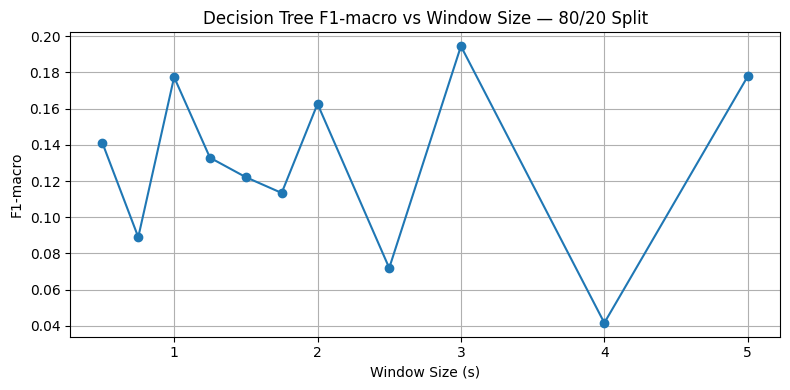

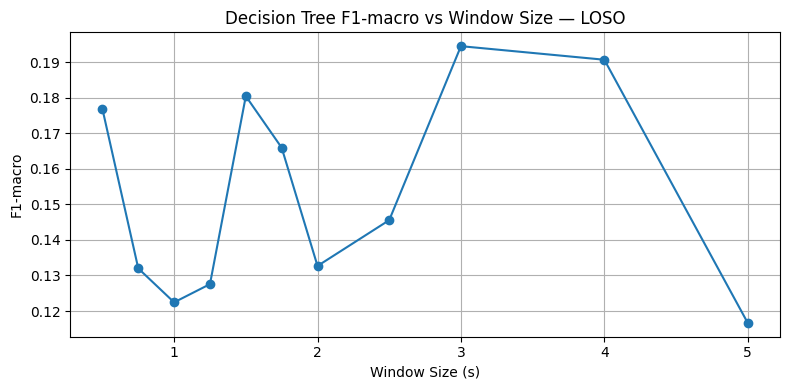

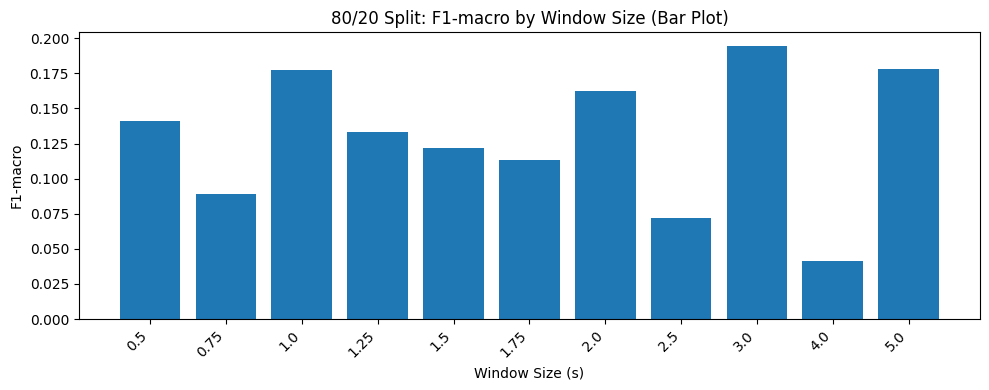

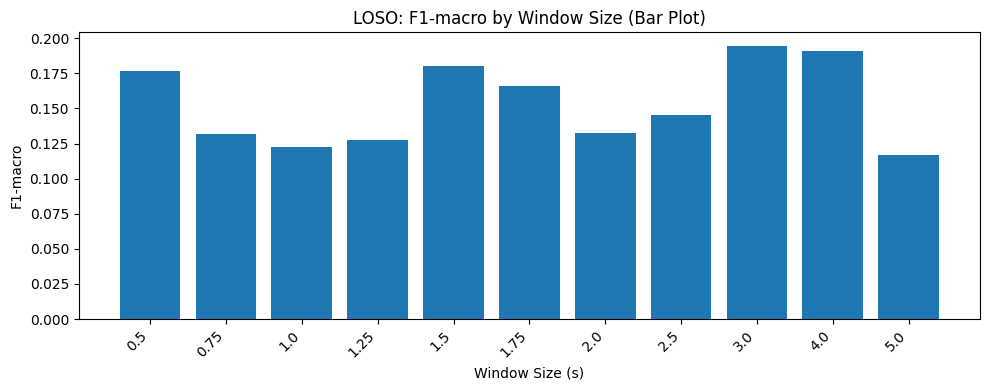

In [39]:
# Line plot (nice for trends)
plt.figure(figsize=(8,4))
plt.plot(compare_df.index, compare_df["Split_F1_macro"], marker="o")
plt.xlabel("Window Size (s)")
plt.ylabel("F1-macro")
plt.title("Decision Tree F1-macro vs Window Size — 80/20 Split")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(compare_df.index, compare_df["LOSO_F1_macro"], marker="o")
plt.xlabel("Window Size (s)")
plt.ylabel("F1-macro")
plt.title("Decision Tree F1-macro vs Window Size — LOSO")
plt.grid(True)
plt.tight_layout()
plt.show()

# Bar plots (explicitly required by rubric)
plt.figure(figsize=(10,4))
plt.bar(compare_df.index.astype(str), compare_df["Split_F1_macro"])
plt.xlabel("Window Size (s)")
plt.ylabel("F1-macro")
plt.title("80/20 Split: F1-macro by Window Size (Bar Plot)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.bar(compare_df.index.astype(str), compare_df["LOSO_F1_macro"])
plt.xlabel("Window Size (s)")
plt.ylabel("F1-macro")
plt.title("LOSO: F1-macro by Window Size (Bar Plot)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [40]:
# choose best LOSO window
FINAL_WINDOW_SEC = best_loso_w

print("Final chosen window size:", FINAL_WINDOW_SEC, "seconds")

Final chosen window size: 3.0 seconds


Final 80/20 split metrics: {'Accuracy': 0.2222, 'Precision_macro': 0.1806, 'Recall_macro': 0.2222, 'F1_macro': 0.1944}


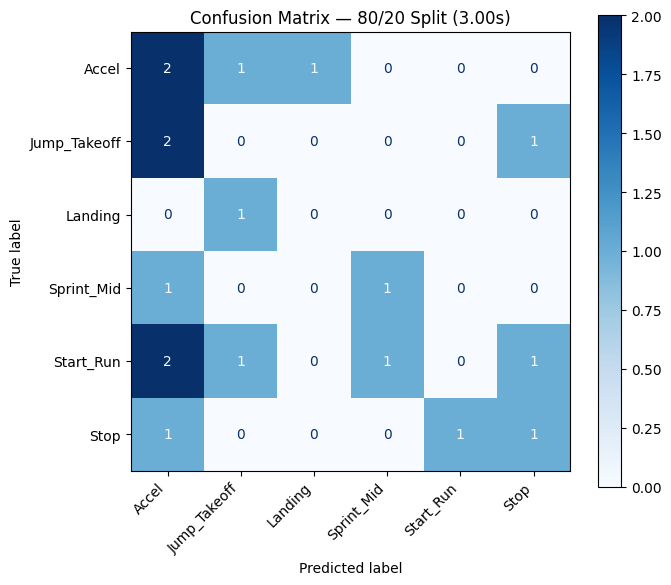

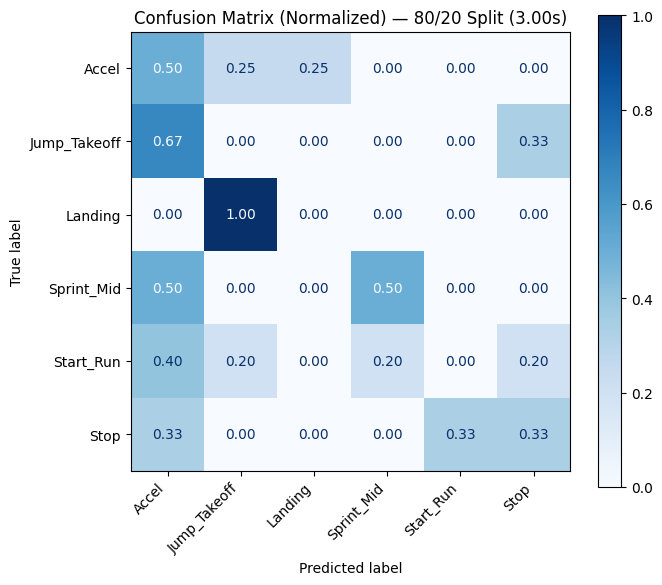

In [42]:
feat_df_final = build_feature_table(df, FINAL_WINDOW_SEC, OVERLAP, ts_col, id_col, label_col, FS, hr_col=hr_col)

# Prepare X/y (IMPORTANT: numeric-only features)
X = feat_df_final.drop(columns=["label", "athlete_id"], errors="ignore").copy()

# Drop metadata columns that are not model features (and include datetimes)
X = X.drop(columns=["window_idx", "start_ts", "end_ts"], errors="ignore")

# Drop ANY remaining datetime columns just in case
dt_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.datetime64)]
if dt_cols:
    X = X.drop(columns=dt_cols, errors="ignore")

# Force numeric (coerce any stray objects to NaN)
X = X.apply(pd.to_numeric, errors="coerce")

# Labels
le = LabelEncoder()
y = le.fit_transform(feat_df_final["label"].astype(str))

# Remove singleton classes
counts = pd.Series(y).value_counts()
valid = counts[counts >= 2].index
mask = pd.Series(y).isin(valid)
X, y = X.loc[mask].reset_index(drop=True), pd.Series(y)[mask].to_numpy()

# Drop any rows with NaNs after coercion
keep = ~np.isnan(X.to_numpy()).any(axis=1)
X = X.loc[keep].reset_index(drop=True)
y = y[keep]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

model = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Metrics table row (final split)
final_split_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
    "Recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
    "F1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0),
}
print("Final 80/20 split metrics:", {k: round(v,4) for k,v in final_split_metrics.items()})

# Confusion matrix (counts)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=True)
plt.title(f"Confusion Matrix — 80/20 Split ({FINAL_WINDOW_SEC:.2f}s)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Confusion matrix (normalized)
cm_norm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(cm_norm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(ax=ax, cmap="Blues", values_format=".2f", colorbar=True)
plt.title(f"Confusion Matrix (Normalized) — 80/20 Split ({FINAL_WINDOW_SEC:.2f}s)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Final LOSO metrics: {'Accuracy': 0.2333, 'Precision_macro': 0.2104, 'Recall_macro': 0.1946, 'F1_macro': 0.1945}


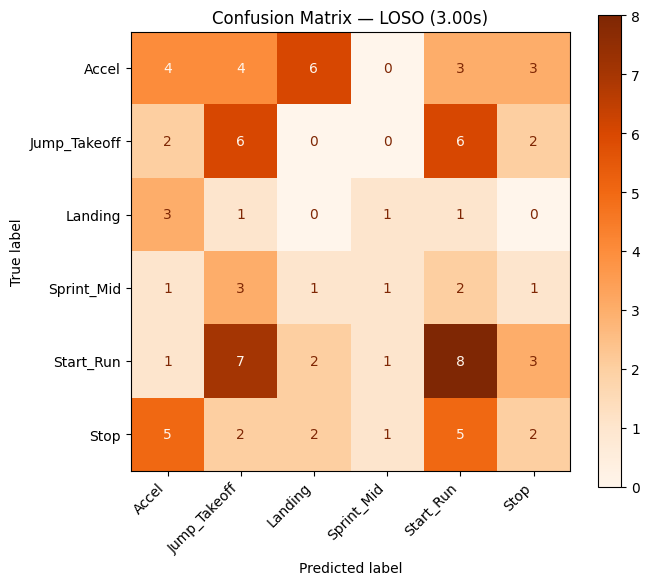

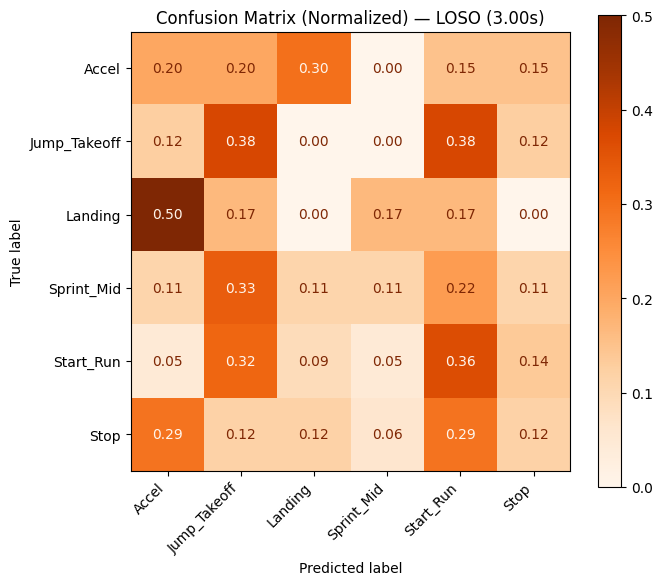

In [43]:
metrics_loso, (y_true_loso, y_pred_loso), le_loso = eval_loso_decision_tree(
    feat_df_final, max_depth=MAX_DEPTH, random_state=RANDOM_STATE
)

print("Final LOSO metrics:", {k: round(v,4) for k,v in metrics_loso.items() if k != "n_windows"})

# Confusion matrix (counts)
cm_loso = confusion_matrix(y_true_loso, y_pred_loso)
disp = ConfusionMatrixDisplay(cm_loso, display_labels=le_loso.classes_)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(ax=ax, cmap="Oranges", values_format="d", colorbar=True)
plt.title(f"Confusion Matrix — LOSO ({FINAL_WINDOW_SEC:.2f}s)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Confusion matrix (normalized)
cm_loso_norm = confusion_matrix(y_true_loso, y_pred_loso, normalize="true")
disp = ConfusionMatrixDisplay(cm_loso_norm, display_labels=le_loso.classes_)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(ax=ax, cmap="Oranges", values_format=".2f", colorbar=True)
plt.title(f"Confusion Matrix (Normalized) — LOSO ({FINAL_WINDOW_SEC:.2f}s)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [44]:
def top_confusions(y_true, y_pred, labels, top_k=10):
    cm = confusion_matrix(y_true, y_pred)
    errors = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i != j and cm[i, j] > 0:
                errors.append((int(cm[i, j]), labels[i], labels[j]))
    errors.sort(reverse=True)
    return errors[:top_k]

print("Top misclassifications (80/20 split):")
for c, t, p in top_confusions(y_test, y_pred, le.classes_, top_k=10):
    print(f"{c}: {t} → {p}")

print("\nTop misclassifications (LOSO):")
for c, t, p in top_confusions(y_true_loso, y_pred_loso, le_loso.classes_, top_k=10):
    print(f"{c}: {t} → {p}")

Top misclassifications (80/20 split):
2: Start_Run → Accel
2: Jump_Takeoff → Accel
1: Stop → Start_Run
1: Stop → Accel
1: Start_Run → Stop
1: Start_Run → Sprint_Mid
1: Start_Run → Jump_Takeoff
1: Sprint_Mid → Accel
1: Landing → Jump_Takeoff
1: Jump_Takeoff → Stop

Top misclassifications (LOSO):
7: Start_Run → Jump_Takeoff
6: Jump_Takeoff → Start_Run
6: Accel → Landing
5: Stop → Start_Run
5: Stop → Accel
4: Accel → Jump_Takeoff
3: Start_Run → Stop
3: Sprint_Mid → Jump_Takeoff
3: Landing → Accel
3: Accel → Stop


### Error Analysis and Final Evaluation

Analysis of misclassifications shows that most errors occur between biomechanically similar or transition-heavy activities, such as Start_Run, Accel, and Jump_Takeoff. These activities share overlapping motion patterns and often co-occur within the same window, making perfect separation difficult at the window level. This pattern is consistent across both the 80/20 split and LOSO evaluations.

LOSO misclassifications are more frequent, as expected, because the model must generalize to an unseen athlete whose movement dynamics differ from those seen during training. Importantly, the types of errors remain consistent, indicating that the model’s behavior is systematic rather than random.

A 3.0-second sliding window provides the best balance between temporal context and generalization, achieving the highest performance under both evaluation protocols while limiting confusion to inherently ambiguous activity transitions.

# Fatigue Detection (Add-On)

In addition to classifying movement events with a Decision Tree, we add a **simple fatigue indicator** on top of the existing windowed features.

Because we do not have explicit fatigue labels or long controlled sessions, fatigue is treated as a **relative change from baseline** rather than a separate supervised classification problem.

## Basic Idea

Fatigue is estimated by tracking how certain physiological and motion features **drift over time** compared to an athlete’s early-session baseline.

Intuitively:
- Heart rate tends to increase for similar effort
- Movement becomes more variable and less regular
- Dominant movement frequency may decrease

We summarize these changes using a single **Fatigue Index** per window.

## Baseline

For each athlete:
- The first portion of the session (e.g., first 20% of windows) is treated as a **baseline**
- Mean and standard deviation are computed for fatigue-related features
- Later windows are compared to this baseline using z-scores

This makes the fatigue estimate **athlete-relative**, which is more reasonable given limited data.

## Fatigue Index

For each window, we compute z-scores relative to baseline for features such as:
- Heart rate mean
- Acceleration variability (std, RMS)
- Spectral entropy
- Dominant frequency (inverted, since it may decrease with fatigue)

These z-scores are averaged into a single value:

- Values near 0 -> similar to baseline
- Larger positive values -> greater deviation (more fatigue-like behavior)

In [45]:
# These are the window-level features we’ll use for a simple fatigue proxy.
# +1 means "fatigue tends to increase this"; -1 means "fatigue tends to decrease this".
FATIGUE_FEATURES = {
    "HR_mean": +1,
    "AccMag_std": +1,
    "AccMag_entropy": +1,
    "AccMag_rms": +1,
    "AccMag_domfreq": -1,
}

BASELINE_FRAC = 0.2

In [46]:
def available_fatigue_features(feat_df, fatigue_features_dict):
    feats = [f for f in fatigue_features_dict.keys() if f in feat_df.columns]
    if len(feats) == 0:
        raise ValueError(
            "None of the requested FATIGUE_FEATURES exist in feat_df. "
            "Check your feature names or which signals were available."
        )
    return feats

In [47]:
# Compute baseline stats per athlete (mean/std on early windows)

def compute_baselines(feat_df, feature_cols, baseline_frac=0.2):
    """
    Returns dict:
      baselines[athlete_id][feature] = (mean, std)
    Baseline windows = earliest baseline_frac of windows (by start_ts if present, else window_idx).
    """
    baselines = {}

    # Choose ordering column for "early session"
    if "start_ts" in feat_df.columns:
        order_col = "start_ts"
    elif "window_idx" in feat_df.columns:
        order_col = "window_idx"
    else:
        order_col = None  # fallback: current row order

    for aid, g in feat_df.groupby("athlete_id"):
        if order_col is not None:
            g = g.sort_values(order_col)

        n_base = max(3, int(len(g) * baseline_frac))
        base = g.iloc[:n_base]

        # numeric conversion safeguards
        base_num = base[feature_cols].apply(pd.to_numeric, errors="coerce")

        baseline_stats = {}
        for col in feature_cols:
            mu = float(base_num[col].mean())
            sd = float(base_num[col].std())
            if not np.isfinite(sd) or sd < 1e-6:
                sd = 1e-6
            baseline_stats[col] = (mu, sd)

        baselines[aid] = baseline_stats

    return baselines

In [48]:
# Compute Fatigue Index per window

def add_fatigue_index(feat_df, fatigue_features_dict, baseline_frac=0.2):
    """
    Adds:
      - FatigueIndex (float)
      - FatigueState (optional categorical bins)
    Uses athlete-relative z-scores vs baseline.
    """
    out = feat_df.copy()

    # Only use features that exist
    feature_cols = available_fatigue_features(out, fatigue_features_dict)

    # Compute baselines
    baselines = compute_baselines(out, feature_cols, baseline_frac=baseline_frac)

    # Compute FI row-by-row (vectorized by group to keep it simple and stable)
    FI = np.full(len(out), np.nan, dtype=float)

    for aid, g in out.groupby("athlete_id"):
        idx = g.index.to_numpy()
        base = baselines[aid]

        g_num = g[feature_cols].apply(pd.to_numeric, errors="coerce")

        z_stack = []
        for col in feature_cols:
            mu, sd = base[col]
            z = (g_num[col].to_numpy() - mu) / sd

            direction = fatigue_features_dict[col]
            z = direction * z  # invert features expected to decrease
            z_stack.append(z)

        # average across available features
        Z = np.vstack(z_stack)  # shape: (n_features, n_windows_for_athlete)
        FI[idx] = np.nanmean(Z, axis=0)

    out["FatigueIndex"] = FI

    # Optional bins/states (heuristic)
    out["FatigueState"] = pd.cut(
        out["FatigueIndex"],
        bins=[-np.inf, 0.5, 1.5, np.inf],
        labels=["Fresh", "Moderate Fatigue", "High Fatigue"],
    )

    return out

In [49]:
# Apply fatigue detection to your final feature table

feat_df_fatigue = add_fatigue_index(
    feat_df_final,
    fatigue_features_dict=FATIGUE_FEATURES,
    baseline_frac=BASELINE_FRAC
)

feat_df_fatigue[["athlete_id", "start_ts", "label", "FatigueIndex", "FatigueState"]].head()

,athlete_id,start_ts,label,FatigueIndex,FatigueState
0,A001,2025-05-11 12:14:53.417747,Start_Run,0.872045,Moderate Fatigue
1,A001,2025-05-11 12:14:54.917747,Stop,-0.059198,Fresh
2,A001,2025-05-11 12:14:56.417747,Stop,-0.812848,Fresh
3,A001,2025-05-11 12:14:57.917747,Start_Run,-1.136841,Fresh
4,A001,2025-05-11 12:14:59.417747,Sprint_Mid,-0.674233,Fresh


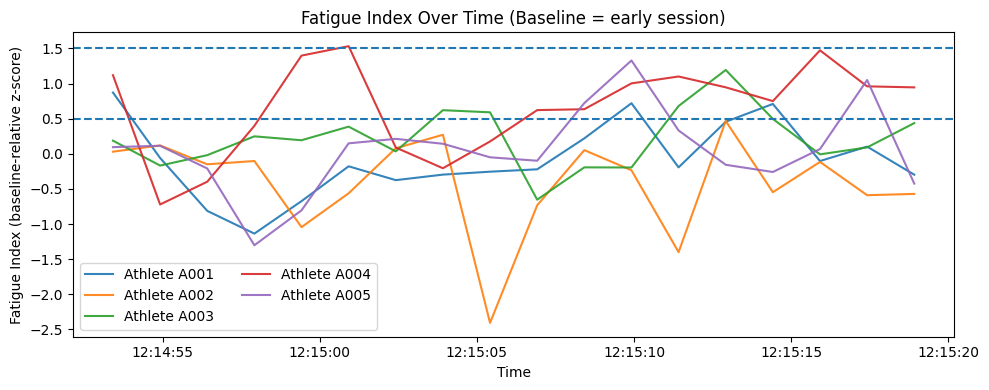

In [50]:
#  Plot Fatigue Index over time (per athlete)

plt.figure(figsize=(10,4))

for aid, g in feat_df_fatigue.groupby("athlete_id"):
    # sort for a clean line
    if "start_ts" in g.columns:
        g = g.sort_values("start_ts")
        x = g["start_ts"]
    else:
        g = g.sort_values("window_idx")
        x = g["window_idx"]

    plt.plot(x, g["FatigueIndex"], label=f"Athlete {aid}", alpha=0.9)

# heuristic thresholds
plt.axhline(0.5, linestyle="--")
plt.axhline(1.5, linestyle="--")

plt.xlabel("Time" if "start_ts" in feat_df_fatigue.columns else "Window Index")
plt.ylabel("Fatigue Index (baseline-relative z-score)")
plt.title("Fatigue Index Over Time (Baseline = early session)")
plt.legend(loc="best", ncol=2)
plt.tight_layout()
plt.show()

The fatigue index plot shows how each athlete’s movement and physiological patterns deviate from their early-session baseline over time. Most athletes exhibit fluctuating but generally increasing deviations during later portions of the session, with peaks corresponding to periods of higher intensity activity. This behavior is consistent with prior findings that fatigue manifests as increased heart rate drift, movement variability, and signal irregularity rather than a strictly monotonic trend. The subject-relative baseline approach allows these changes to be observed despite inter-athlete differences and limited data, making the fatigue index a useful contextual signal for interpreting event classification performance and model errors.

These trends align with established wearable-sensing research showing that fatigue is best characterized by deviations from individual baselines rather than absolute thresholds (Borresen & Lambert, 2009; Merriaux et al., 2017).

Borresen, J., & Lambert, M. I. (2009). The quantification of training load, the training response and the effect on performance. Sports Medicine.

Merriaux, P., Dupuis, Y., Boutteau, R., Vasseur, P., & Savatier, X. (2017). A study of human gait variability under fatigue conditions using wearable sensors. Sensors.